# Tracking excess mortality across countries during the COVID-19 pandemic with the World Mortality Dataset

## Ariel Karlinsky & Dmitry Kobak

### *eLife*, 2021: https://elifesciences.org/articles/69336

This notebook runs the entire analysis for the paper, produces the final figures, and exports the results in CSV tables.

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
import datetime
import statsmodels.api as sm

In [2]:
import math

def round_to_n(x, n, one_digit_below_100=True):
    if x==0:
        return 0
    if np.isnan(x):
        return np.nan
    if one_digit_below_100 and np.abs(x) < 100:
        return np.round(x/10) * 10
    else:
        return round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [3]:
# https://github.com/akarlinsky/world_mortality/blob/main/world_mortality.csv?raw=true
df = pd.read_csv('frozen-data/world_mortality.csv')

# https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv?raw=true
df_official_jhu = pd.read_csv('frozen-data/owid-covid-data.csv')

# https://covid19.who.int/WHO-COVID-19-global-data.csv
df_official_who = pd.read_csv('frozen-data/WHO-COVID-19-global-data.csv')

# https://github.com/datasets/population/blob/master/data/population.csv?raw=true
df_population_wb = pd.read_csv('frozen-data/population.csv')

# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
df_population_wpp = pd.read_csv('frozen-data/WPP2019_TotalPopulationBySex.csv')

df_population_wpp = df_population_wpp[(df_population_wpp['Variant']=='Medium')&(df_population_wpp['Time']==2020)]
df_population = df_population_wpp.rename(columns={'Location':'Country Name', 'PopTotal':'Value'})
df_population['Value'] = df_population['Value'] * 1000

In [4]:
renames = {'The United Kingdom': 'United Kingdom',
           'United States of America': 'United States',
           'Bosnia and Herzegovina': 'Bosnia',
           'Republic of Korea': 'South Korea',
           'Bolivia (Plurinational State of)': 'Bolivia',
           'Iran (Islamic Republic of)': 'Iran',
           'Kosovo[1]': 'Kosovo',
           'Republic of Moldova': 'Moldova',
           'Russian Federation': 'Russia',
          
           'Korea, Rep.': 'South Korea',
           'Slovak Republic': 'Slovakia',
           'Iran, Islamic Rep.': 'Iran',
           'Czech Republic': 'Czechia',
           'Egypt, Arab Rep.': 'Egypt',
           'Hong Kong SAR, China': 'Hong Kong',
           'Kyrgyz Republic': 'Kyrgyzstan',
           'Macao SAR, China': 'Macao',
          
           'China, Hong Kong SAR':'Hong Kong',
           'China, Macao SAR': 'Macao',
           'China, Taiwan Province of China': 'Taiwan'}

for c in renames:
    df_official_who.loc[df_official_who['Country'] == c, 'Country'] = renames[c]
    df_official_jhu.loc[df_official_jhu['location'] == c, 'location'] = renames[c]
    df_population.loc[df_population['Country Name'] == c, 'Country Name'] = renames[c]
    df_population_wb.loc[df_population_wb['Country Name'] == c, 'Country Name'] = renames[c]

In [5]:
# Week of the first official covid19 death, to start the excess mortality calculation

def get_excess_begin(country, datapoints_per_year = 53):    
    if datapoints_per_year > 12:
        beg = 9  # week 10
    
    elif datapoints_per_year > 4 and datapoints_per_year <= 12:
        beg = 2  # March
        
    elif datapoints_per_year == 4:
        beg = 0 
        
    return beg

In [6]:
def predict(X, country, verbose=False):    
    # Fit regression model on pre-2020 data 
    ind = (X[:,0] < 2020) & (X[:,1]<53)
    m = np.max(X[ind,1])
    onehot = np.zeros((np.sum(ind), m))
    for i,k in enumerate(X[ind,1]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((X[ind,:1], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, X[ind,2])
        
    if verbose:
        est = sm.OLS(X[ind,2], predictors).fit()
        print(est.summary())
    
    # Compute 2020 baseline
    ind2 = X[:,0] == 2020
    predictors2020 = np.concatenate((np.ones((m,1))*2020, np.eye(m)), axis=1)
    baseline = reg.predict(predictors2020)
            
    # Week 53 usually does not have enough data, so we'll use 
    # the same baseline value as for week 52
    if np.max(X[:,1])==53:
        baseline = np.concatenate((baseline, [baseline[-1]]))
    
    # Excess mortality
    ind2 = X[:,0] == 2020
    diff2020 = X[ind2,2] - baseline[X[ind2,1]-1]
    ind3 = X[:,0] == 2021
    diff2021 = X[ind3,2] - baseline[X[ind3,1]-1]
    excess_begin = get_excess_begin(country, baseline.size)
    total_excess = np.sum(diff2020[excess_begin:]) + np.sum(diff2021)
        
    # Manual fit for uncertainty computation
    if np.unique(X[ind,0]).size > 1:
        y = X[ind,2][:,np.newaxis]
        beta = np.linalg.pinv(predictors.T @ predictors) @ predictors.T @ y
        yhat = predictors @ beta
        sigma2 = np.sum((y-yhat)**2) / (y.size-predictors.shape[1])
        
        S = np.linalg.pinv(predictors.T @ predictors)
        w = np.zeros((m, 1))
        w[X[(X[:,0] == 2020) & (X[:,1] < 53),1]-1] = 1
        if np.max(X[:,1])==53:
            w[52-1] += 1
        w[:excess_begin] = 0
        w[X[ind3,1]-1] += 1
        
        p = 0
        for i,ww in enumerate(w):
            p += predictors2020[i] * ww
        p = p[:,np.newaxis]
                        
        predictive_var = sigma2 * np.sum(w) + sigma2 * p.T @ S @ p
        total_excess_std = np.sqrt(predictive_var)[0][0]
    else:
        total_excess_std = np.nan
       
    return baseline, total_excess, excess_begin, total_excess_std

In [7]:
countries = np.unique(df['country_name'])
print(f'Total countries: {countries.size}')

allcountries = {}

heatwave_excess = np.zeros(countries.size)

for i, country in enumerate(countries):    
    print('.', end='')
        
    assert(np.unique(df[(df['country_name']==country)]['time_unit']).size == 1)
    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
      
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    # https://en.wikipedia.org/wiki/Casualties_of_the_2020_Nagorno-Karabakh_war
    if country=='Armenia':
        total_excess -= 4000 # 3360
    if country=='Azerbaijan':
        total_excess -= 4000 # (2854+50)
        
    # August 2020 heatwave, weeks 32-34
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany']:
        heatwave = np.sum(X[(X[:,0]==2020)&(X[:,1]>=32)&(X[:,1]<=34), 2])
        heatwave -= np.sum(baseline[32-1:34+1-1])
        total_excess -= heatwave
        heatwave_excess[i] = heatwave
        
    allcountries[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

Total countries: 103
.......................................................................................................

In [8]:
for country in ['Russia', 'United States']:    
    print(country)

    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
      
    _ = predict(X, country, verbose=True)

Russia
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     10.22
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.83e-09
Time:                        21:51:55   Log-Likelihood:                -597.55
No. Observations:                  60   AIC:                             1221.
Df Residuals:                      47   BIC:                             1248.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2346.2167    527.727     -4.446  

In [9]:
# Heat wave deaths (weeks 32-34)

for i, country in enumerate(countries):
    if heatwave_excess[i] > 0:
        print(f'{country:12} -- {heatwave_excess[i]:.0f}')

Belgium      -- 1526
France       -- 1545
Germany      -- 3736
Luxembourg   -- 31
Netherlands  -- 663


In [10]:
# Countries with data not from 2015 but later

for c in allcountries:
    if allcountries[c][0][0][0] != 2015:
        print(f'{c:17} -- data start with {allcountries[c][0][0][0]}')

Argentina         -- data start with 0
Chile             -- data start with 2016
French Polynesia  -- data start with 2017
Germany           -- data start with 2016
Peru              -- data start with 2017
South Africa      -- data start with 0
Transnistria      -- data start with 2016


In [11]:
# Export the baselines

with open('export/baselines.csv','w') as f:
    for c in allcountries:
        X, baseline, total_excess, excess_begin, total_excess_std = allcountries[c] 
        for i,b in enumerate(baseline):
            f.write(f'{c}, {i+1}, {b:.1f}\n')

In [12]:
# Population

pops = np.zeros(len(allcountries.keys()))
for i,m in enumerate(allcountries.keys()):
    # Russia's population should include Crimea because mortality figures do 
    # Ukraine's population should *not* include Crimea
    if m=='Russia':
        pops[i] = 146748590 # Rosstat, estimate for 1 Jan 2020    
    elif m=='Ukraine':
        pops[i] = 41762138  # Ukrstat 2020, according to Wikipedia
    elif m=='Transnistria':
        pops[i] = 465200    # NSO
    elif m=='Kosovo':
        pops[i] = df_population_wb[df_population_wb['Country Name']==m]['Value'].values[-1]
    else:
        pops[i] = df_population[df_population['Country Name']==m]['Value'].values[-1]
        
pops[countries=='Serbia'] = pops[countries=='Serbia'] - pops[countries=='Kosovo']

In [13]:
# Daily reported numbers during the same time period

official = np.zeros(len(allcountries.keys()))

for i,m in enumerate(allcountries.keys()):
    howmany = np.max(allcountries[m][0][:,1])
    last = allcountries[m][0][-1][1]
    lastyear = allcountries[m][0][-1][0]
    
    if howmany > 12:
        d = f'{lastyear}-W{last:02}'
        r = datetime.datetime.strptime(d + '-0', "%G-W%V-%w")
        r = str(r)[:10]
    elif howmany > 4:
        if last < 12:
            r = f'{lastyear}-{last+1:02}-01'
        else:
            r = f'{lastyear+1}-01-01'
    elif howmany == 4:
        if m == 'Iran':
            # https://twitter.com/Mahan_Ghafari/status/1336338070249951236
            r = '2020-09-21'
        else:
            if last < 4:
                r = f'{lastyear}-{last*3+1:02}-01'
            else:
                r = f'{lastyear+1}-01-01'
    else:
        r = ''
        
    if m == 'Transnistria':
        # From the Telegram channel https://t.me/novostipmrcom
        # End of June: 1219, May: 1195
        # End of April: 1112, March: 907, February: 689, January: 626, end of 2020: 473
        official[i] = 1195 
        continue
        
    if m in ['Taiwan', 'Macao', 'Hong Kong']:
        official[i] = df_official_jhu[(df_official_jhu['location']==m)
                                      &(df_official_jhu['date']==r)]['total_deaths'].values[0]
        if np.isnan(official[i]):
            official[i] = 0
    else:
        official[i] = df_official_who[(df_official_who['Country']==m)
                                  &(df_official_who['Date_reported']==r)]['Cumulative_deaths'].values[0]

In [14]:
# Sum over the entire dataset

totalexcess = 0
for c in allcountries:
    totalexcess += allcountries[c][2]
    
print(f'Total excess: {totalexcess:,.0f}')
print(f'Official Covid deats: {np.nansum(official):,.0f}')
print(f'Ratio: {totalexcess / np.nansum(official) :.2f}')

Total excess: 3,993,684
Official Covid deats: 2,896,259
Ratio: 1.38


In [15]:
zs = np.zeros(countries.size)
for i,c in enumerate(allcountries):
    zs[i] = allcountries[c][2]/allcountries[c][4]

print(f'Statistically significant increase:  {np.sum(zs>2)}')      
print(f'Statistically significant decrease:  {np.sum(zs<-2)}')      
print(f'Not statistically significant:       {np.sum(np.abs(zs)<2)}')      
print(f'Impossible to assess significance:   {np.sum(np.isnan(zs))}')      

Statistically significant increase:  69
Statistically significant decrease:  7
Not statistically significant:       25
Impossible to assess significance:   2


In [16]:
baselinelengths = np.zeros(countries.size)
for i,c in enumerate(allcountries):
    baselinelengths[i] = allcountries[c][1].size

print(f'Weekly data: {np.sum(baselinelengths>50)}')
print(f'Monthly data: {np.sum((baselinelengths<50) & (baselinelengths>4))}')
print(f'Quarterly data: {np.sum(baselinelengths==4)}')

Weekly data: 50
Monthly data: 51
Quarterly data: 2


## Megafigure

In [17]:
def stairs(x,y):
    xx = []
    yy = []
    for i in range(x.size):
        if i>0 and x[i]-x[i-1] > 1:
            skip = (x[i]-x[i-1]) - 1
            xx = xx + [np.nan, np.nan] * skip
            yy = yy + [np.nan, np.nan] * skip
        xx = xx + [x[i]-.5, x[i]+.5]
        yy = yy + [y[i], y[i]]
    return xx, yy

In [18]:
def percent_increase(country, zero_not_signif=False):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    d = total_excess/np.sum(baseline)*100
        
    if zero_not_signif and np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000 # for alphabetical sorting
    return d

In [19]:
undercounts = np.zeros(countries.size)
for i,country in enumerate(countries):
    if allcountries[country][2] < 0:
        undercounts[i] = np.nan
    else:
        undercounts[i] = allcountries[country][2] / official[i]

undercounts[np.isin(countries, ['Hong Kong', 'Thailand', 'Cuba'])] = np.nan

<IPython.core.display.Javascript object>


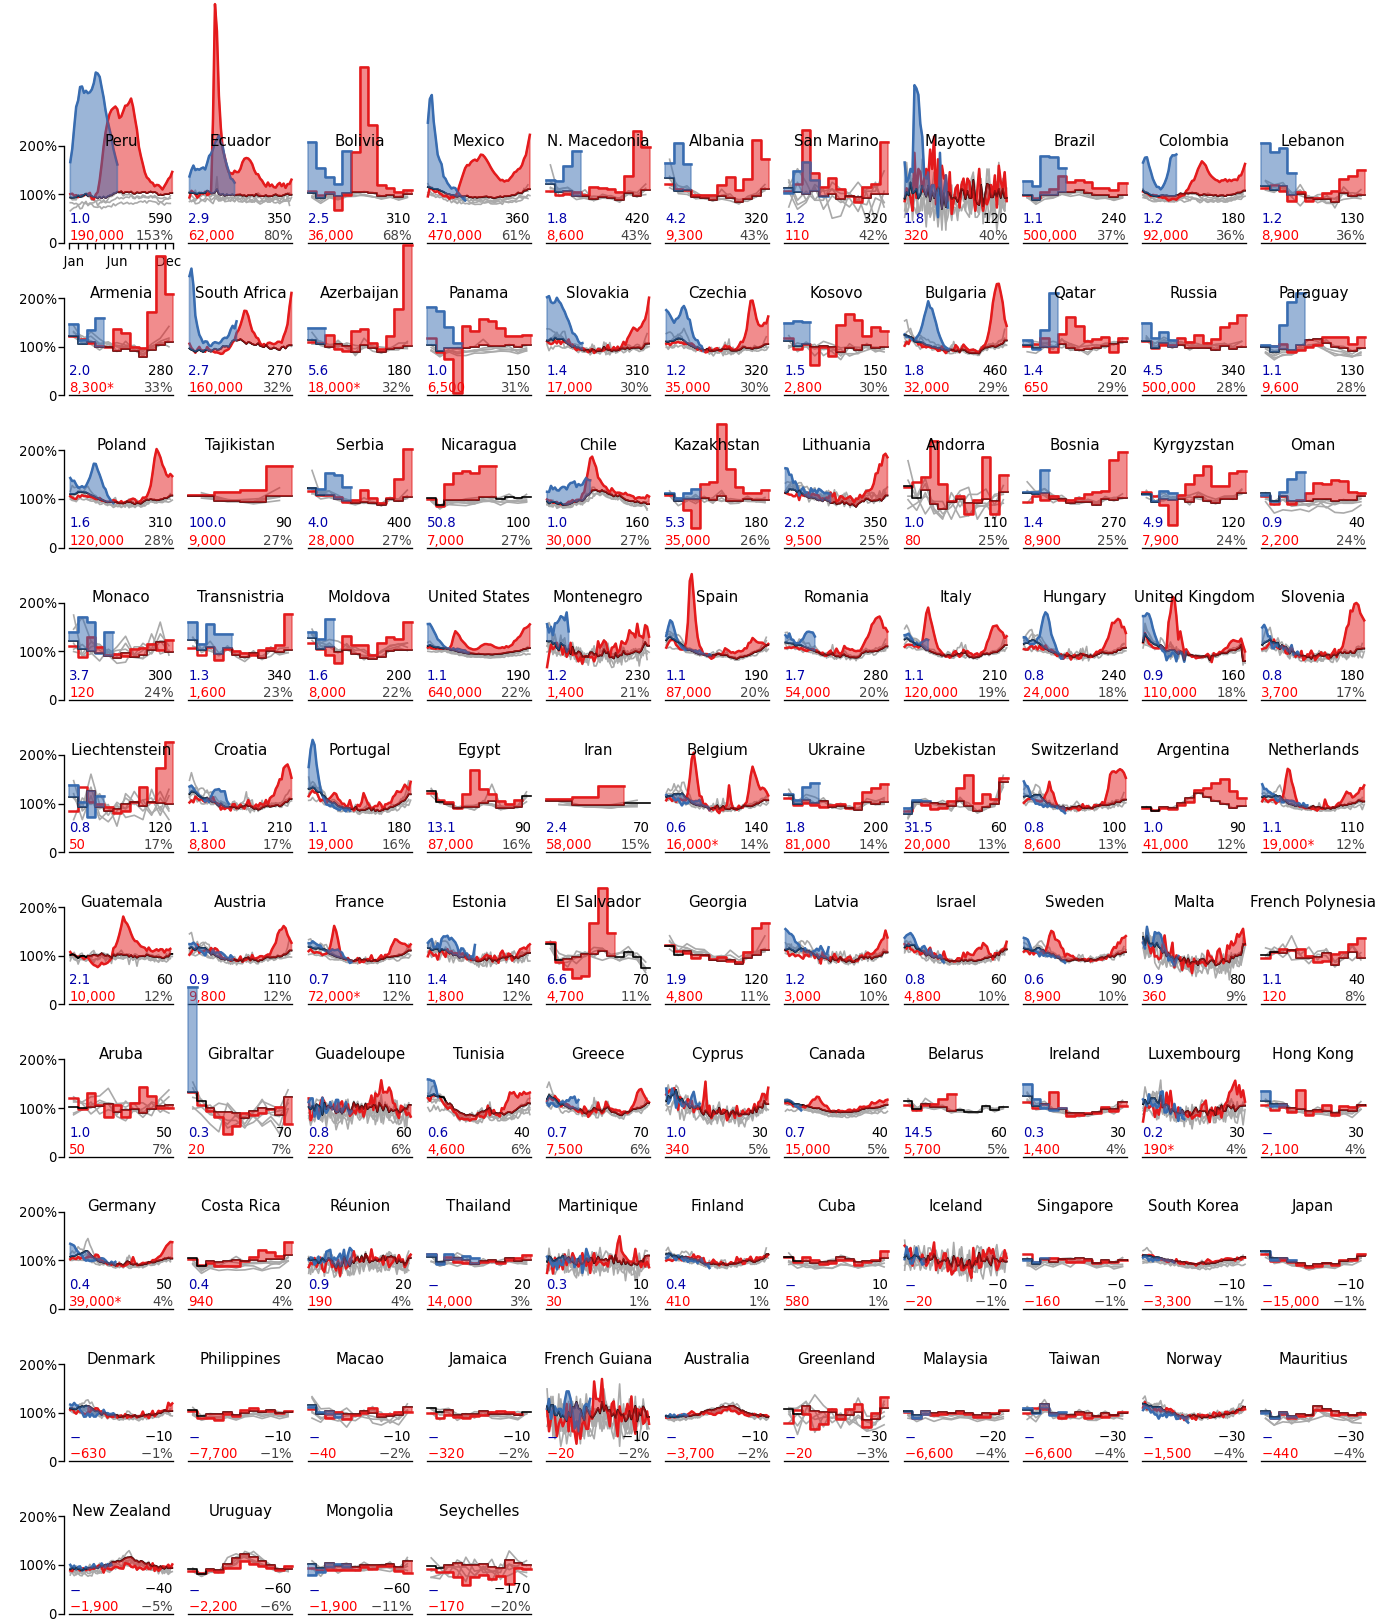

In [20]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    ds[i] = percent_increase(country, zero_not_signif=False)
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(7.7*1.5, 9*1.5))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    ax = plt.axes([.05+(i%11)*.086, .85-np.floor(i/11)*.094, .075, .06])
    
    col2020 = '#e41a1c' 
    col2021 = '#386cb0'
    alpha = .5
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
        
    if baseline.size < 50:
        xx1,yy1 = stairs(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2])
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)
    
        if np.sum(X[:,0]==2021)>0:
            xx3,yy3 = stairs(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2])
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)

        xx2,yy2 = stairs(np.arange(baseline.size)+1, baseline)
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
    else:
        xx1,yy1 = X[X[:,0]==2020, 1], X[X[:,0]==2020, 2]
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)

        if np.sum(X[:,0]==2021)>1:
            xx3,yy3 = X[X[:,0]==2021, 1], X[X[:,0]==2021, 2]
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)
        elif np.sum(X[:,0]==2021)==1:
            plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color=col2021, markersize=3, clip_on=False)
        plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

        xx2,yy2 = np.arange(baseline.size)+1, baseline
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
        
    toplabel = .32
    bottomlabel = .03
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    thresh = 0
    z = np.abs(total_excess)/total_excess_std
    minus = '$-{}$' if total_excess<0 else ''
    if np.isnan(z) or z > thresh:
        plt.text(.0, bottomlabel, minus+f'{round_to_n(np.abs(total_excess),2):,.0f}'+star, 
                 transform=plt.gca().transAxes, color='r', fontsize=fs)
        plt.text(1, bottomlabel, minus+f'{np.abs(percent_increase(country)):.0f}%', 
                 transform=plt.gca().transAxes, ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, minus+f'{round_to_n(np.abs(total_excess)/pops[ind][i]*100000,2):.0f}', 
                 transform=plt.gca().transAxes, ha='right', va='top', color='k', fontsize=fs)
        if ~np.isnan(undercounts[ind][i]):
            plt.text(.0, toplabel, f'{undercounts[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, f'$-$', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, bottomlabel, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    if baseline.size < 50:
        poly1 = np.concatenate((xx1[excess_begin*2:], xx1[excess_begin*2:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin*2:], yy2[:len(yy1)][excess_begin*2:][::-1]))
    else:
        poly1 = np.concatenate((xx1[excess_begin:], xx1[excess_begin:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin:], yy2[:len(yy1)][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=alpha, zorder=5, clip_on=False)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021) > 1 or (baseline.size < 50 and np.sum(X[:,0]==2021) > 0):
        poly1 = np.concatenate((xx3, xx3[::-1]))
        poly2 = np.concatenate((yy3[:len(yy3)], yy2[:len(yy3)][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor=col2021, edgecolor=col2021, alpha=alpha, zorder=5, clip_on=False)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,2*np.mean(baseline)])
    plt.xlim([.5, baseline.size+.5])
    plt.xticks([])
    
    plt.title(country if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=9, y=.9, zorder=100)
        
    if i%11 > 0:
        plt.yticks([])
        sns.despine(left=True, ax=ax)
    else:
        plt.yticks([0,np.mean(baseline),np.mean(baseline)*2], ['0', '100%', '200%'], fontsize=7)
        sns.despine(ax=ax, offset={'left':3})
        plt.gca().set_yticklabels(['0', '100%', '200%'], fontsize=8)
        plt.gca().yaxis.set_tick_params(pad=1)
        
    if i==0:
        plt.xticks(np.linspace(.5,53.5,13), ['  Jan','','','','','  Jun','','','','','','  Dec',''], fontsize=8)

plt.savefig('figures/megafigure.pdf')
plt.savefig('figures/megafigure.png', dpi=200)

<IPython.core.display.Javascript object>


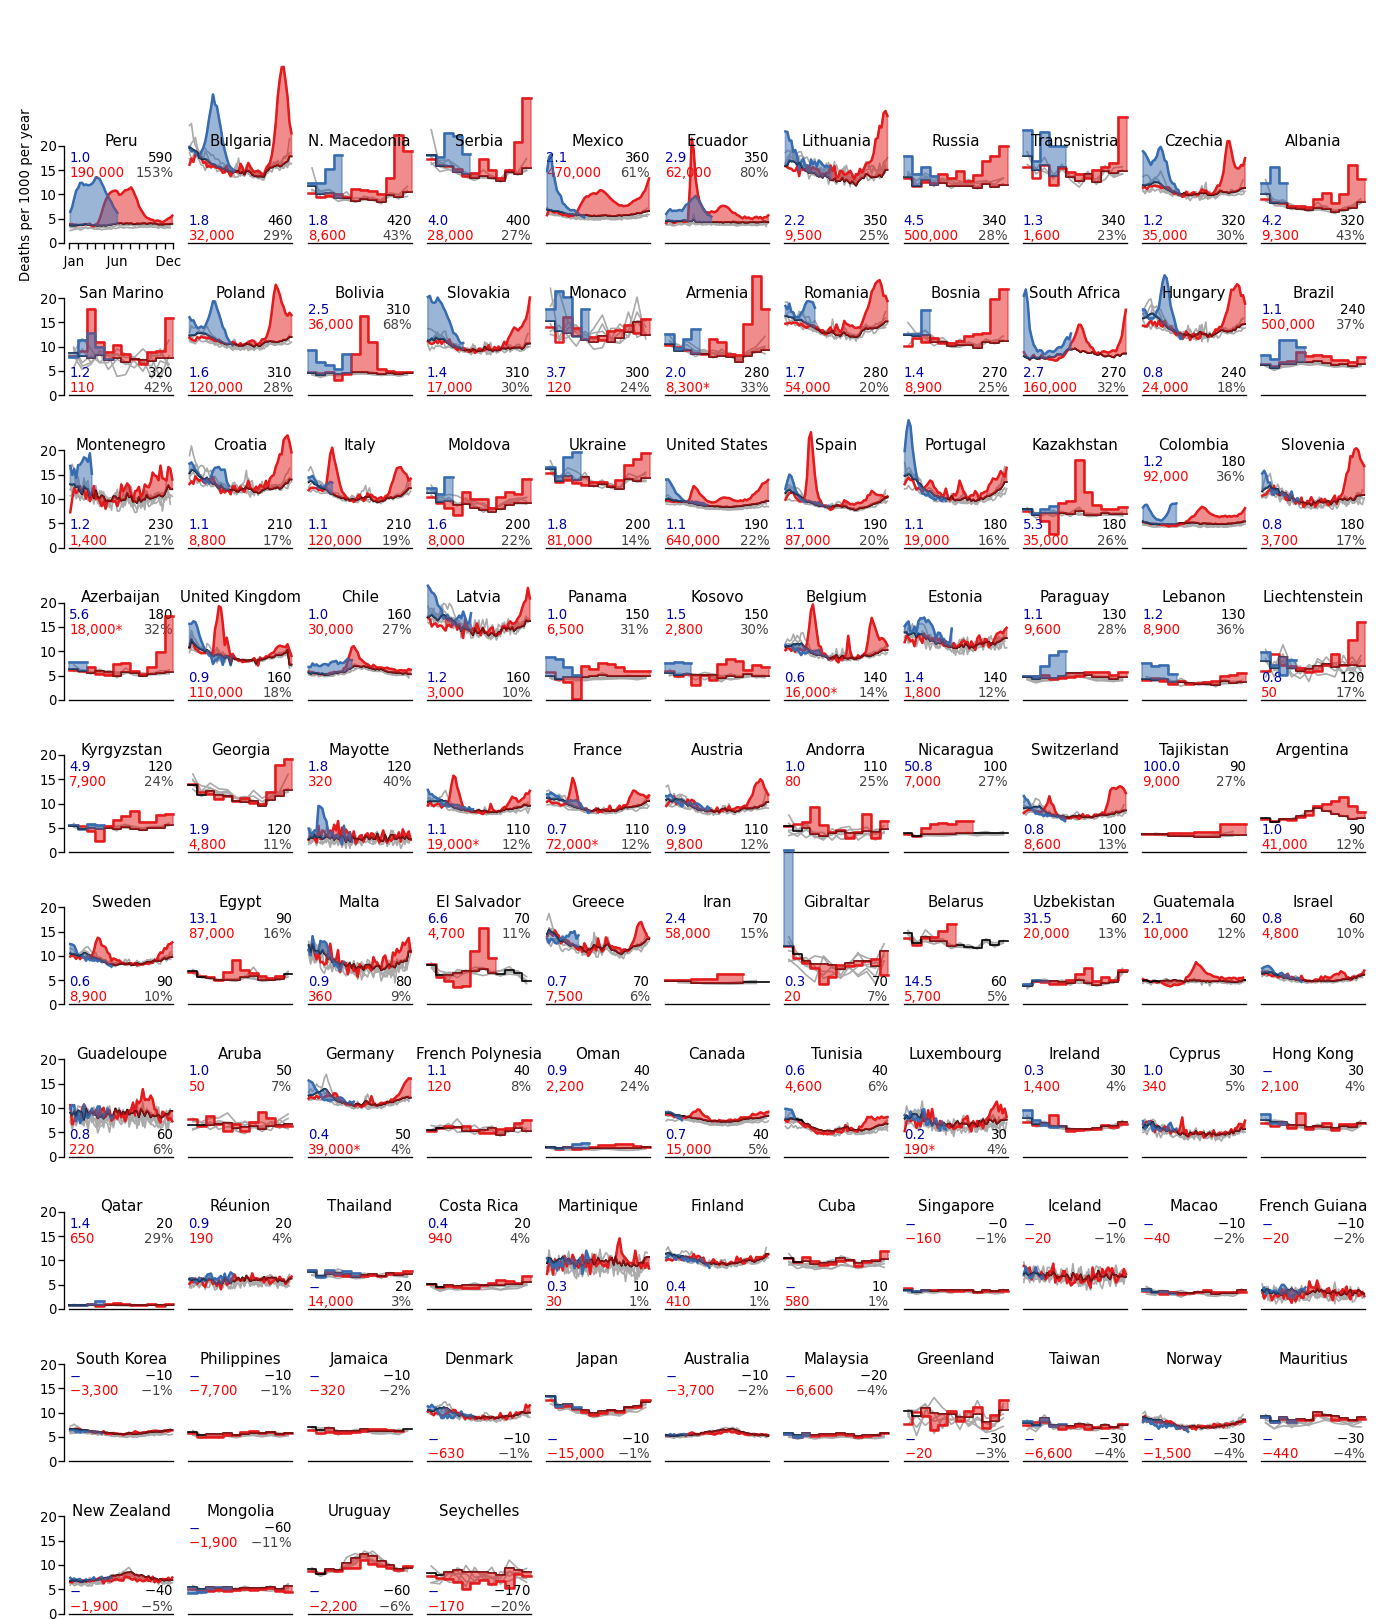

In [21]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    ds[i] = total_excess/pops[i]
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(7.7*1.5, 9*1.5))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    ax = plt.axes([.05+(i%11)*.086, .85-np.floor(i/11)*.094, .075, .06])
    
    col2020 = '#e41a1c' 
    col2021 = '#386cb0'
    alpha = .5
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    X = X.copy().astype(float)
    baseline = baseline.copy()
    X[:,2] = X[:,2] / pops[ind][i] * 1000 * baseline.size
    baseline = baseline / pops[ind][i] * 1000 * baseline.size

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
        
    if baseline.size < 50:
        xx1,yy1 = stairs(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2])
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)
    
        if np.sum(X[:,0]==2021)>0:
            xx3,yy3 = stairs(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2])
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)

        xx2,yy2 = stairs(np.arange(baseline.size)+1, baseline)
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
    else:
        xx1,yy1 = X[X[:,0]==2020, 1], X[X[:,0]==2020, 2]
        plt.plot(xx1, yy1, color=col2020, lw=1.5, clip_on=False)

        if np.sum(X[:,0]==2021)>1:
            xx3,yy3 = X[X[:,0]==2021, 1], X[X[:,0]==2021, 2]
            plt.plot(xx3, yy3, color=col2021, lw=1.5, clip_on=False)
        elif np.sum(X[:,0]==2021)==1:
            plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color=col2021, markersize=3, clip_on=False)
        plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

        xx2,yy2 = np.arange(baseline.size)+1, baseline
        plt.plot(xx2, yy2, color='k', lw=1, clip_on=False)
        
    if np.mean(baseline) > 7:
        toplabel = .3
        bottomlabel = .03
    else:
        toplabel = .95
        bottomlabel = .68
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    thresh = 0
    z = np.abs(total_excess)/total_excess_std
    minus = '$-{}$' if total_excess<0 else ''
    if np.isnan(z) or z > thresh:
        plt.text(.0, bottomlabel, minus+f'{round_to_n(np.abs(total_excess),2):,.0f}'+star, 
                 transform=plt.gca().transAxes, color='r', fontsize=fs)
        plt.text(1, bottomlabel, minus+f'{np.abs(percent_increase(country)):.0f}%', 
                 transform=plt.gca().transAxes, ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, minus+f'{round_to_n(np.abs(total_excess)/pops[ind][i]*100000,2):.0f}', 
                 transform=plt.gca().transAxes, ha='right', va='top', color='k', fontsize=fs)
        if ~np.isnan(undercounts[ind][i]):
            plt.text(.0, toplabel, f'{undercounts[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, f'$-$', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, bottomlabel, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    if baseline.size < 50:
        poly1 = np.concatenate((xx1[excess_begin*2:], xx1[excess_begin*2:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin*2:], yy2[:len(yy1)][excess_begin*2:][::-1]))
    else:
        poly1 = np.concatenate((xx1[excess_begin:], xx1[excess_begin:][::-1]))
        poly2 = np.concatenate((yy1[excess_begin:], yy2[:len(yy1)][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=alpha, zorder=5, clip_on=False)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021) > 1 or (baseline.size < 50 and np.sum(X[:,0]==2021) > 0):
        poly1 = np.concatenate((xx3, xx3[::-1]))
        poly2 = np.concatenate((yy3[:len(yy3)], yy2[:len(yy3)][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor=col2021, edgecolor=col2021, alpha=alpha, zorder=5, clip_on=False)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,20])
    plt.xlim([.5, baseline.size+.5])
    plt.xticks([])
        
    plt.title(country if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=9, y=.9, zorder=100)
        
    if i%11 > 0:
        plt.yticks([])
        sns.despine(left=True, ax=ax)
    else:
        plt.yticks([0,5,10,15,20], fontsize=7)
        sns.despine(ax=ax, offset={'left':3})
        plt.gca().set_yticklabels([0,5,10,15,20], fontsize=8)
        plt.gca().yaxis.set_tick_params(pad=1)
        
    if i==0:
        plt.ylabel('Deaths per 1000 per year', fontsize=8)        
        plt.xticks(np.linspace(.5,53.5,13), ['  Jan','','','','','  Jun','','','','','','  Dec',''], fontsize=8)

plt.savefig('figures/megafigure-suppl.pdf')
plt.savefig('figures/megafigure-suppl.png', dpi=200)

## Export the megatable

In [22]:
def until_date(country):
    howmany = np.max(allcountries[country][0][:,1])
    last = allcountries[country][0][-1][1]
    lastyear = allcountries[country][0][-1][0]

    if howmany>12:
        date = datetime.datetime.strptime(f'{lastyear}-W{last:02}-0', "%G-W%V-%w")
    elif howmany>4:
        if last<12:
            date = datetime.datetime.strptime(f'{lastyear}-{last+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
    else:
        if last<4:
            date = datetime.datetime.strptime(f'{lastyear}-{last*3+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
        
        if country=='Iran':
            if last>1:
                date = datetime.datetime.strptime(f'{lastyear}-{last*3:02}-21', "%Y-%m-%d")
            else:
                date = datetime.datetime.strptime(f'{lastyear-1}-12-21', "%Y-%m-%d")

    date = date.strftime('%b %d, %Y')
    
    if howmany>12:
        time_format = 'w'
    elif howmany>4:
        time_format = 'm'
    else:
        time_format = 'q'
    
    return date, time_format
    

print('Country                     Until  Type   Confirmed      Excess      std      z  Undercount  Per 100k   Increase')
print('----------------------------------------------------------------------------------------------------------------')

for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 0
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        if ~np.isnan(undercounts[i]) and allcountries[c][2] > 0:
            undercount = f'       {undercounts[i]:5.1f}' 
        else:
            undercount = '         ---'
        per100k    = f'      {round_to_n(allcountries[c][2]/pops[i]*1e+5,2):4.0f}'
        increase   = f'       {percent_increase(c):3.0f}%'

    else:
        undercount = ''
        per100k    = ''
        increase   = ''
    
    print(f'{c:20} {until:15}  {time_format}     {round_to_n(official[i],2):7,.0f}'
          f'     {round_to_n(allcountries[c][2],2):7,.0f} ± {round_to_n(allcountries[c][4],2):6,.0f}' 
          f'  {z:5.1f}' + undercount + per100k + increase)

Country                     Until  Type   Confirmed      Excess      std      z  Undercount  Per 100k   Increase
----------------------------------------------------------------------------------------------------------------
Albania              Mar 31, 2021     m       2,200       9,300 ±    810   11.4         4.2       320        43%
Andorra              Dec 31, 2020     m          80          80 ±     30    3.1         1.0       110        25%
Argentina            Dec 31, 2020     m      43,000      41,000 ±    nan    nan         1.0        90        12%
Armenia              Apr 30, 2021     m       4,100       8,300 ±    840   10.0         2.0       280        33%
Aruba                Dec 31, 2020     m          50          50 ±     30    1.5         1.0        50         7%
Australia            Mar 28, 2021     w         910      -3,700 ±  1,000    3.6         ---       -10        -2%
Austria              Jun 13, 2021     w      10,000       9,800 ±  1,400    7.0         0.9     

In [23]:
# LaTeX output

for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 0
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        if ~np.isnan(undercounts[i]) and allcountries[c][2] > 0:
            undercount = f'{undercounts[i]:.1f}' 
        else:
            undercount = '--'
        
        per100k    = f'${round_to_n(allcountries[c][2]/pops[i]*1e+5,2):.0f}$'
        increase   = f'${percent_increase(c):.0f}\%$'

    else:
        undercount = 'n.s.'
        per100k    = 'n.s.'
        increase   = 'n.s.'
        
    minus = '$-$' if allcountries[c][2]<0 else ''
    
    print(f'{c} & {until} & {time_format} & {round_to_n(official[i],2):,.0f} & '
          '' + minus + f'{round_to_n(np.abs(allcountries[c][2]),2):,.0f}'
          f'& $\pm\,${round_to_n(allcountries[c][4],2):,.0f} & ' 
          f'{z:.1f}' + ' & ' + undercount + ' & '  + per100k + ''
          ' & ' + increase + '\\\\')

Albania & Mar 31, 2021 & m & 2,200 & 9,300& $\pm\,$810 & 11.4 & 4.2 & $320$ & $43\%$\\
Andorra & Dec 31, 2020 & m & 80 & 80& $\pm\,$30 & 3.1 & 1.0 & $110$ & $25\%$\\
Argentina & Dec 31, 2020 & m & 43,000 & 41,000& $\pm\,$nan & nan & 1.0 & $90$ & $12\%$\\
Armenia & Apr 30, 2021 & m & 4,100 & 8,300& $\pm\,$840 & 10.0 & 2.0 & $280$ & $33\%$\\
Aruba & Dec 31, 2020 & m & 50 & 50& $\pm\,$30 & 1.5 & 1.0 & $50$ & $7\%$\\
Australia & Mar 28, 2021 & w & 910 & $-$3,700& $\pm\,$1,000 & 3.6 & -- & $-10$ & $-2\%$\\
Austria & Jun 13, 2021 & w & 10,000 & 9,800& $\pm\,$1,400 & 7.0 & 0.9 & $110$ & $12\%$\\
Azerbaijan & Feb 28, 2021 & m & 3,200 & 18,000& $\pm\,$1,400 & 13.0 & 5.6 & $180$ & $32\%$\\
Belarus & Jun 30, 2020 & m & 390 & 5,700& $\pm\,$930 & 6.1 & 14.5 & $60$ & $5\%$\\
Belgium & Jun 13, 2021 & w & 25,000 & 16,000& $\pm\,$1,800 & 8.7 & 0.6 & $140$ & $14\%$\\
Bolivia & May 31, 2021 & m & 14,000 & 36,000& $\pm\,$770 & 46.4 & 2.5 & $310$ & $68\%$\\
Bosnia & Mar 31, 2021 & m & 6,600 & 8,900& $\pm\,

In [24]:
# Export the table

with open('export/excess-mortality.csv','w') as f:
    f.write('Country,Data until,Data type,COVID-19 deaths,Excess deaths,'
            'Excess deaths std,t-statistic,Undercount ratio,Excess per 100k,'
            'Excess as % of annual baseline\n')
    
    for i,c in enumerate(allcountries):
        until, time_format = until_date(c)
         
        per100k    = allcountries[c][2]/pops[i]*1e+5
        increase   = percent_increase(c)
        
        z = np.abs(allcountries[c][2])/allcountries[c][4]
            
        f.write(f'{c},"{until}",{time_format},{official[i]:.0f},{allcountries[c][2]:.0f},'
                f'{allcountries[c][4]:.0f},{z:.1f},{undercounts[i]:.2f},{per100k:.1f},{increase:.1f}\n')

## Leaderboard figure

<IPython.core.display.Javascript object>


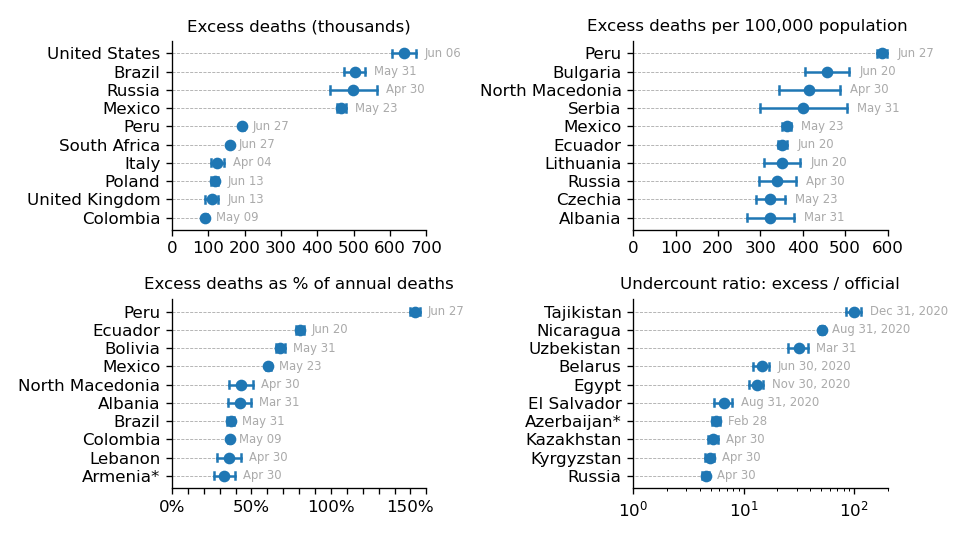

In [25]:
fig = plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / 1000
    z[i] = allcountries[c][4] / 1000 * 1.96
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,700]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600,700])
plt.title('Excess deaths (thousands)', fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text(x[ind][i]+z[ind][i] + 25, -i, d[:6], c='#aaaaaa', fontsize=7, va='center')

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / pops[i] * 1e+5
    z[i] = allcountries[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,600]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500,600])
plt.title('Excess deaths per 100,000 population', x=.45, fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]                    
    plt.text(x[ind][i]+z[ind][i] + 25, -i, d, c='#aaaaaa', fontsize=7, va='center')

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = percent_increase(c)
    z[i] = allcountries[c][4] / np.sum(allcountries[c][1]) * 100 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,160]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160],
           ['0%','','','','','50%','','','','','100%','','','','','150%',''])
plt.title('Excess deaths as % of annual deaths', fontsize=10)

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text(x[ind][i]+z[ind][i] + 5, -i, d, c='#aaaaaa', fontsize=7, va='center')
    

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries[c][2] / (official[i]+.001)
    z[i] = allcountries[c][4] / (official[i]+.001)
    if np.isnan(undercounts[i]):
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [1,200]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official', fontsize=10)
plt.xscale('log')

z[np.isnan(z)] = 0
for i,c in enumerate(np.array([*allcountries.keys()])[ind]):
    d,_ = until_date(c)
    if d[-4:] == '2021':
        d = d[:6]
    plt.text((x[ind][i]+z[ind][i]) * 1.2, -i, d, c='#aaaaaa', fontsize=7, va='center')


sns.despine()
plt.tight_layout()

plt.savefig('figures/leaderboard.pdf')
plt.savefig('figures/leaderboard.png', dpi=200)

## Analysis until the end of 2020

In [26]:
allcountries2020 = {}

for i, country in enumerate(allcountries):    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
    X = X[X[:,0]<2021]

    if X.shape[0]==0 or (X[-1][1] not in [4,12,52,53]):
        allcountries2020[country] = [[],[1],0,0,0]
        continue
      
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    if country=='Armenia':
        total_excess -= 4000
    if country=='Azerbaijan':
        total_excess -= 4000
        
    if country in ['Belgium','France','Luxembourg','Netherlands','Germany']:
        heatwave = np.sum(X[(X[:,0]==2020)&(X[:,1]>=32)&(X[:,1]<=34), 2])
        heatwave -= np.sum(baseline[32-1:34+1-1])
        total_excess -= heatwave

    allcountries2020[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

In [27]:
def percent_increase_2020(country, zero_not_signif=False):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries2020[country] 
    d = total_excess/np.sum(baseline)*100
            
    if zero_not_signif and np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000 # for alphabetical sorting
    return d

In [28]:
official2020 = np.zeros(len(allcountries.keys()))

for i,m in enumerate(allcountries.keys()):        
    if m == 'Transnistria':
        # From the Telegram channel https://t.me/novostipmrcom
        # End of June: 1219, May: 1195
        # End of April: 1112, March: 907, February: 689, January: 626, end of 2020: 473
        official2020[i] = 473 
        continue
        
    r = '2021-01-01'
    
    if m == 'Macao':
        official2020[i] = 0
        continue
        
    if m in ['Taiwan', 'Macao', 'Hong Kong']:
        official2020[i] = df_official_jhu[(df_official_jhu['location']==m)
                                      &(df_official_jhu['date']==r)]['total_deaths'].values[0]
    else:
        official2020[i] = df_official_who[(df_official_who['Country']==m)
                                  &(df_official_who['Date_reported']==r)]['Cumulative_deaths'].values[0]

In [29]:
# Export the table

undercounts2020 = np.zeros(countries.size)
for i,country in enumerate(countries):
    if allcountries2020[country][2] < 0:
        undercounts2020[i] = np.nan
    else:
        undercounts2020[i] = allcountries2020[country][2] / official2020[i]

undercounts2020[np.isin(countries, ['Hong Kong', 'Thailand', 'Cuba', 'Monaco'])] = np.nan

with open('export/excess-mortality-2020.csv','w') as f:
    f.write('Country,Data type,COVID-19 deaths,Excess deaths,'
            'Excess deaths std,t-statistic,Undercount ratio,Excess per 100k,'
            'Excess as % of annual baseline\n')
    
    for i,c in enumerate(allcountries2020):
        until, time_format = until_date(c)
        
        if allcountries2020[c][2] == 0:
            f.write(f'{c},{time_format},{official[i]:.0f},nan,nan,nan,nan,nan,nan\n')
            continue
         
        per100k    = allcountries2020[c][2]/pops[i]*1e+5
        increase   = percent_increase_2020(c)
        
        z = np.abs(allcountries2020[c][2])/allcountries2020[c][4]
            
        f.write(f'{c},{time_format},{official2020[i]:.0f},{allcountries2020[c][2]:.0f},'
                f'{allcountries2020[c][4]:.0f},{z:.1f},{undercounts2020[i]:.2f},{per100k:.1f},{increase:.1f}\n')

<IPython.core.display.Javascript object>


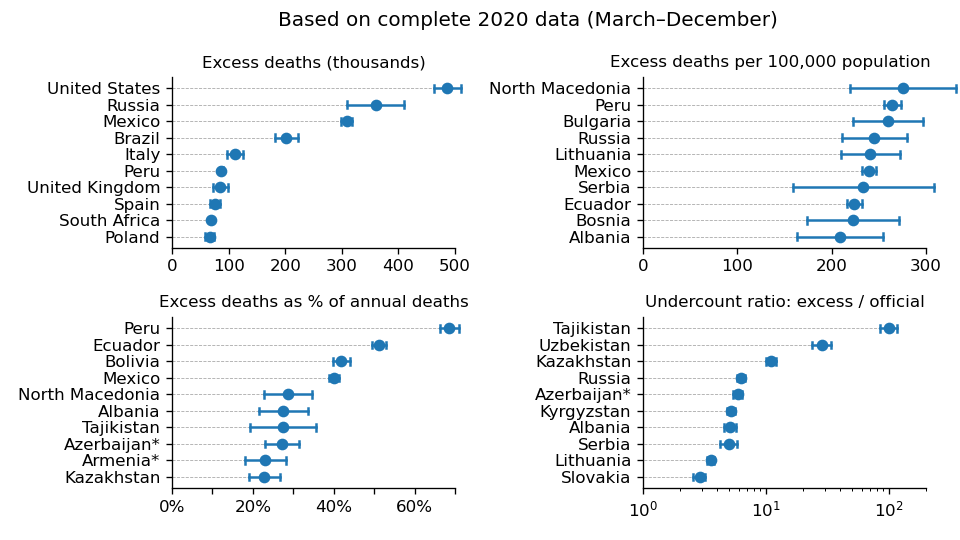

In [30]:
plt.figure(figsize=(8, 4.5))

plt.subplot(221)

x = np.zeros(len(allcountries))
y = np.zeros(len(allcountries))
z = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / 1000
    z[i] = allcountries2020[c][4] / 1000 * 1.96
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,500] 
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300,400,500])
plt.title('Excess deaths (thousands)', fontsize=10)

plt.subplot(222)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / pops[i] * 1e+5
    z[i] = allcountries2020[c][4] / pops[i] * 1e+5 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,300]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,100,200,300])
plt.title('Excess deaths per 100,000 population', x=.45, fontsize=10)

plt.subplot(223)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = percent_increase_2020(c)
    z[i] = allcountries2020[c][4] / np.sum(allcountries2020[c][1]) * 100 * 1.96
    if pops[i] < 500000:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3, clip_on=False)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0],
             lw=1.5, zorder=1, clip_on=False)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], 
             lw=1.5, zorder=1, clip_on=False)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [0,70]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.xticks([0,10,20,30,40,50,60,70],
           ['0%','','20%','','40%','','60%',''])
plt.title('Excess deaths as % of annual deaths', fontsize=10)
    

plt.subplot(224)

x = np.zeros(len(allcountries))
for i,c in enumerate(allcountries):
    x[i] = allcountries2020[c][2] / (official2020[i]+.001)
    z[i] = allcountries2020[c][4] / (official2020[i]+.001)
    if allcountries[c][2]/allcountries[c][4] < 2:
        x[i] = 0
    if c in ['Hong Kong', 'Thailand', 'Cuba','Monaco']:
        x[i] = 0
ind = np.argsort(x)[::-1][:10]
sc = plt.scatter(x[ind],-np.arange(10), zorder=3)
for i in range(10):
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]+z[ind][i]], [-i,-i], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]-z[ind][i], x[ind][i]-z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
    plt.plot([x[ind][i]+z[ind][i], x[ind][i]+z[ind][i]], [-i-.2,-i+.2], c=sc.get_facecolors()[0], lw=1.5, zorder=1)
ticklabels = np.array(list(allcountries.keys()))[ind]
addstar = np.isin(ticklabels, ['Armenia', 'Azerbaijan'])
ticklabels[addstar] = [t+'*' for t in ticklabels[addstar]]
plt.yticks(-np.arange(10), ticklabels)
xl = [1,200]
for i in range(10):
    plt.plot([0,x[ind][i]], [-i,-i], '--', lw=.5, color='#aaaaaa', zorder=0)
plt.xlim(xl)
plt.title('Undercount ratio: excess / official', fontsize=10)
plt.xscale('log')

plt.suptitle('Based on complete 2020 data (March–December)', x=.55)
sns.despine()
plt.tight_layout()

plt.savefig('figures/leaderboard-suppl.pdf')
plt.savefig('figures/leaderboard-suppl.png', dpi=200)

## Tracking between excess and official Covid deaths

In [31]:
def comparison_who(country):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    excess2020 = X[X[:,0]==2020, 2] - baseline[:np.sum(X[:,0]==2020)]
    excess2021 = X[X[:,0]==2021, 2] - baseline[:np.sum(X[:,0]==2021)]
    excess = np.concatenate((excess2020, excess2021))
    
    if baseline.size > 50:
        official = np.zeros(53+52) * np.nan
        for w in range(1,54):
            r = datetime.datetime.strptime(f'{2020}-W{w:02}-1', "%G-W%V-%w") # Monday
            r = str(r)[:10]
    
            ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
            if np.any(np.array(ind)):
                official[w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]

        for w in range(1,53):
            r = datetime.datetime.strptime(f'{2021}-W{w:02}-1', "%G-W%V-%w")
            r = str(r)[:10]
    
            ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
            if np.any(np.array(ind)):
                official[53 + w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]    
    
        official = np.diff(official)
    
        # Take out a reporting spike
        if country=='Ecuador':
            official[35] = np.nan
            
    elif baseline.size == 12:
        official = np.zeros(12+12) * np.nan
        for w in range(1,13):
            r = f'2020-{w:02}-01'
                
            if country in ['Taiwan', 'Macao', 'Hong Kong']:
                ind = (df_official_jhu['location']==country) & (df_official_jhu['date']==r)
                if np.any(np.array(ind)):
                    official[w-1] = df_official_jhu[ind]['total_deaths'].values[0]
            else:
                ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
                if np.any(np.array(ind)):
                    official[w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]

        for w in range(1,13):
            r = f'2021-{w:02}-01'
    
            if country in ['Taiwan', 'Macao', 'Hong Kong']:
                ind = (df_official_jhu['location']==country) & (df_official_jhu['date']==r)
                if np.any(np.array(ind)):
                    official[12 + w-1] = df_official_jhu[ind]['total_deaths'].values[0]
            else:
                ind = (df_official_who['Country']==country) & (df_official_who['Date_reported']==r)
                if np.any(np.array(ind)):
                    official[12 + w-1] = df_official_who[ind]['Cumulative_deaths'].values[0]    
    
        official = np.diff(official)
    
    return excess, official

<IPython.core.display.Javascript object>


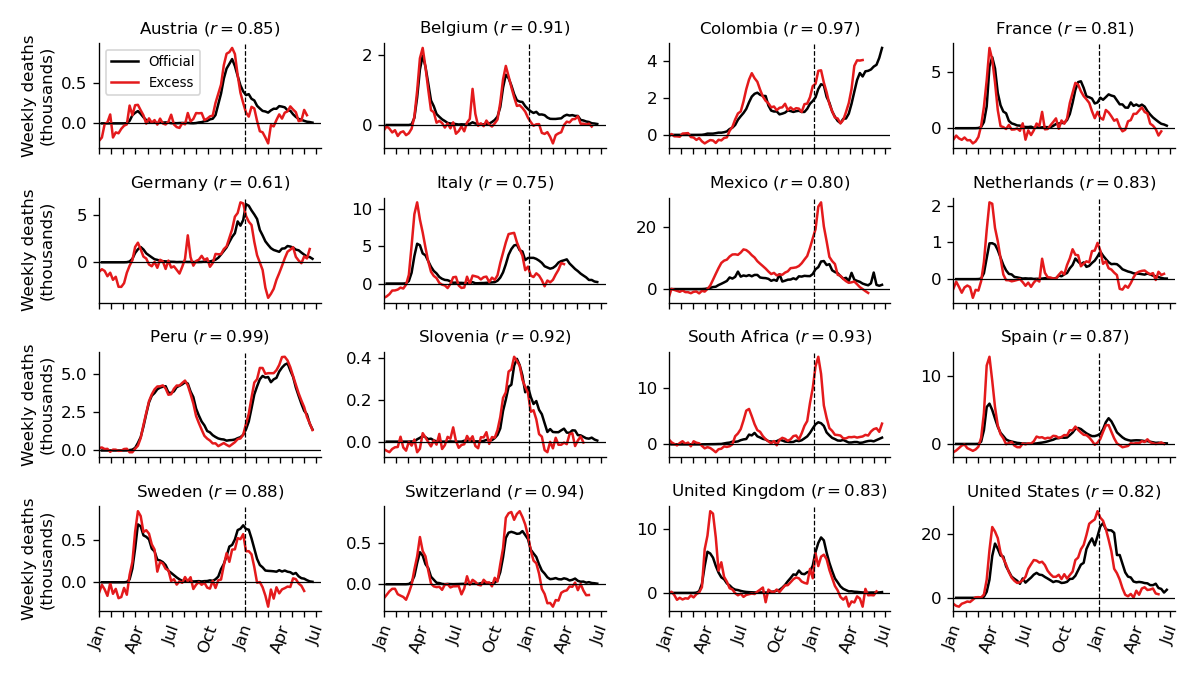

................

In [32]:
countries = ['Austria','Belgium','Colombia','France','Germany','Italy',
             'Mexico','Netherlands','Peru','Slovenia','South Africa','Spain',
             'Sweden','Switzerland','United Kingdom','United States']

countries = sorted(countries)

fig = plt.figure(figsize=(10, 4.5 * 10/8))

for i, country in enumerate(countries):
    print('.', end='')

    plt.subplot(4,4,i+1)
    excess, officialweekly = comparison_who(country)
    
    plt.plot(officialweekly/1000, 'k', label='Official', lw=1.5)
    plt.plot(excess/1000, '#e41a1c', label='Excess', lw=1.5)
    
    x = excess[get_excess_begin(country):]
    y = officialweekly[get_excess_begin(country):excess.size]
    ind = ~np.isnan(x) & ~np.isnan(y)
    r = np.corrcoef(x[ind], y[ind])[0,1]

    plt.xlim([0,80])
    plt.plot([0,80], [0,0], 'k', lw=.75)
    yl = plt.ylim()
    plt.plot([52.5,52.5], yl, 'k--', lw=.75)
    plt.ylim(yl)
    plt.title(f'{country} ($r={r:.2f}$)', fontsize=10)

    lab1 = ['Jan','','','Apr','','','Jul','','','Oct','','',
            'Jan','','','Apr','','','Jul']
    lab2 = [''] * len(lab1)
    plt.xticks(np.concatenate((np.linspace(0,52.5,13),
                           np.linspace(52.5 + 51.5/12, 52.5 + 51.5/12 * 6, 6))),
           lab1 if i>=12 else lab2, 
               rotation=70)
    
    if i == 0:
        plt.legend(fontsize=8)

    if i % 4 == 0:
        plt.ylabel('Weekly deaths\n(thousands)')

sns.despine()
plt.gcf().align_labels()
plt.tight_layout()

plt.savefig('figures/tracking.pdf')
plt.savefig('figures/tracking.png', dpi=200)

In [33]:
# Estimate for influenza / other winter-season infectious diseases

countries = np.unique(df['country_name'])

for country in ['Germany', 'Austria', 'Belgium', 'France', 'Sweden', 'Slovenia']:
    excess, officialweekly = comparison_who(country)
    delta = np.sum(officialweekly[40:53+16] - excess[40:53+16])
    deltanorm = delta / np.sum(allcountries[country][1]) * 100
    deltapop = delta / pops[countries==country][0] * 100_000

    print(f'{country}: {deltanorm:.1f}%, {deltapop:.0f} per 100k, {delta:.0f} deaths')

Germany: 3.9%, 45 per 100k, 37716 deaths
Austria: 2.3%, 22 per 100k, 1964 deaths
Belgium: 5.9%, 56 per 100k, 6534 deaths
France: 4.3%, 41 per 100k, 26616 deaths
Sweden: 5.5%, 50 per 100k, 5021 deaths
Slovenia: 3.5%, 36 per 100k, 747 deaths
